In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

import tensorflow as tf
from src import vrae, train, utils
import numpy as np

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

[]


In [2]:
batch_size = 96
#time_size = 256*5
train_set = np.load('/works/Data/wellysis/preprocessed/5s_mit_minmax_30000_train.npy')
print("Total Data Set shape is : {}".format(train_set.shape))
time_size = train_set.shape[1]
print(train_set.min(), train_set.max(), train_set.mean(), train_set.std())

Total Data Set shape is : (30000, 640, 1)
0.0 1.0 0.5113967094006754 0.0580595980601414


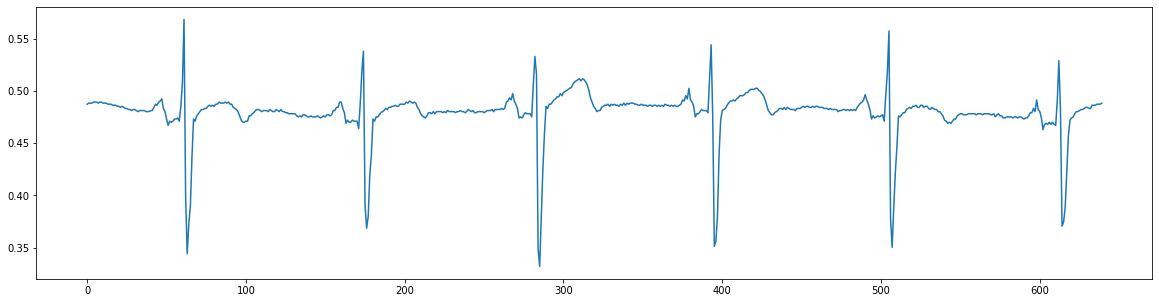

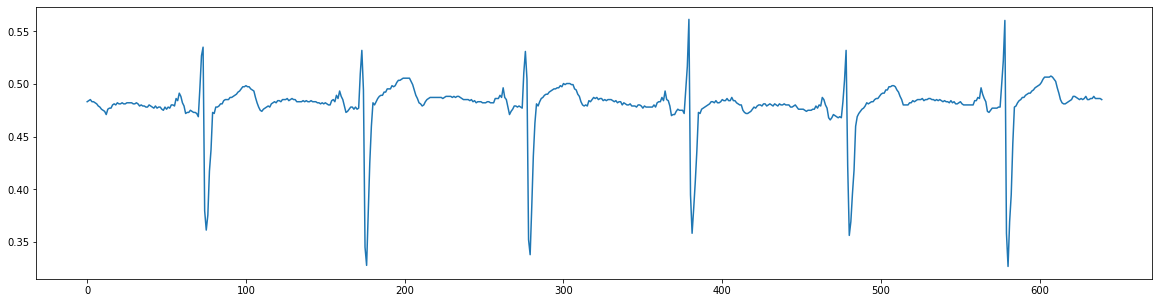

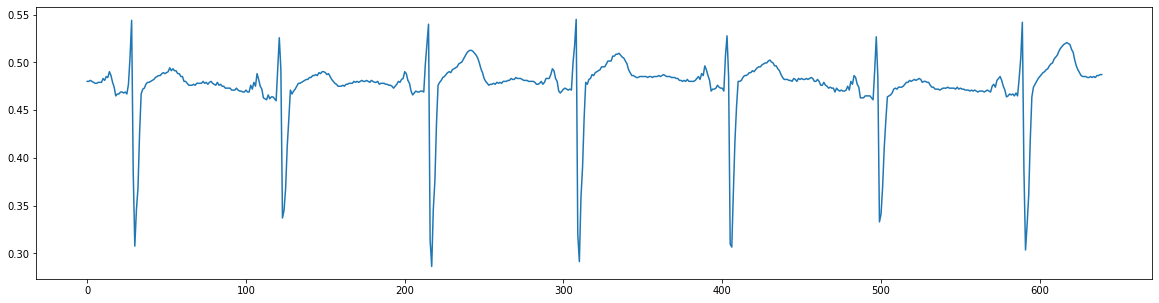

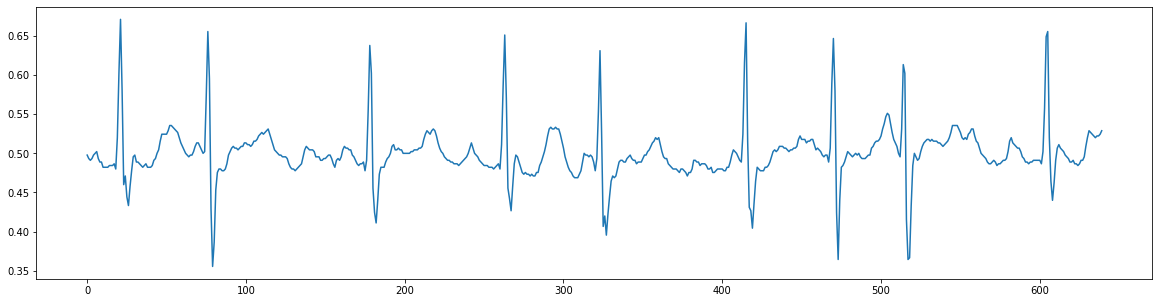

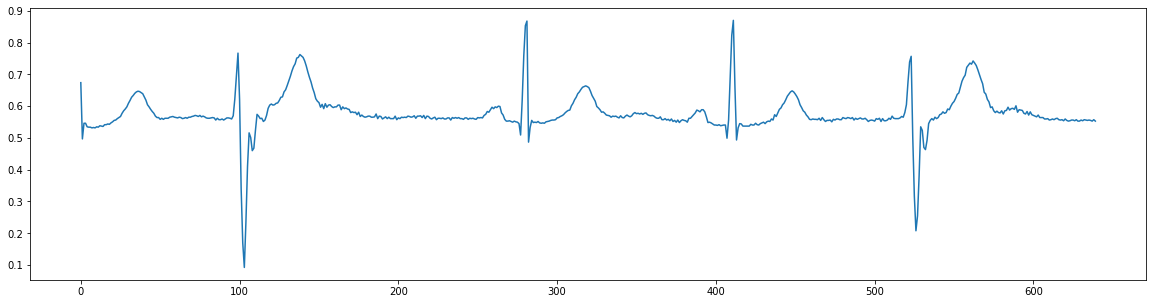

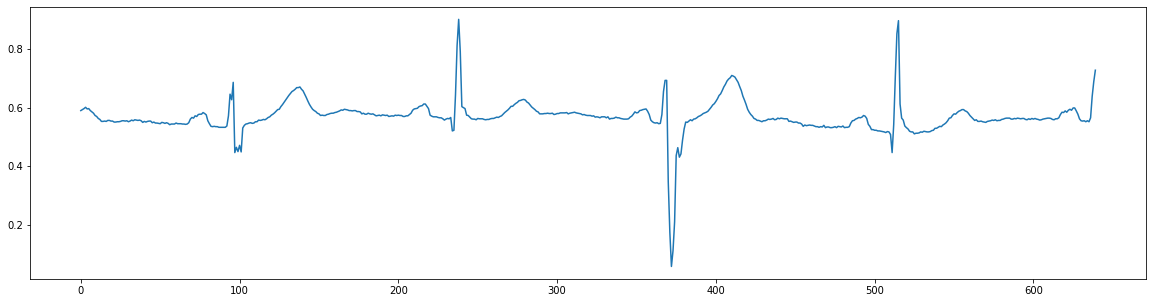

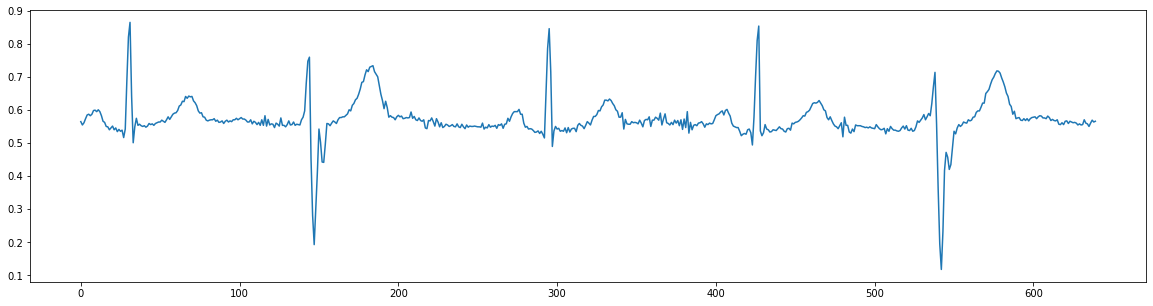

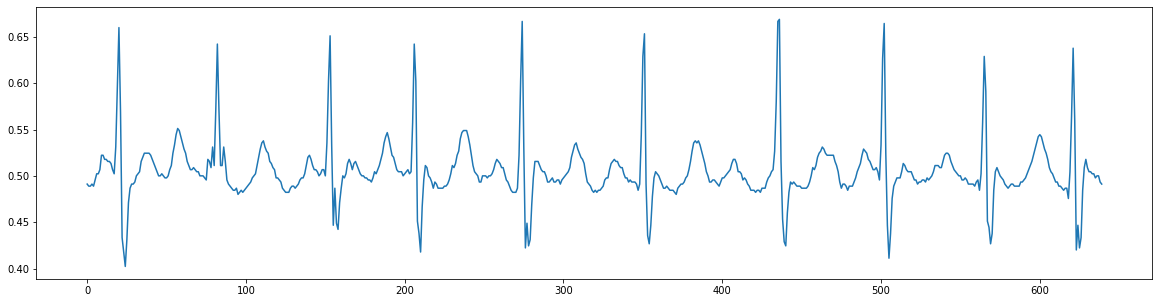

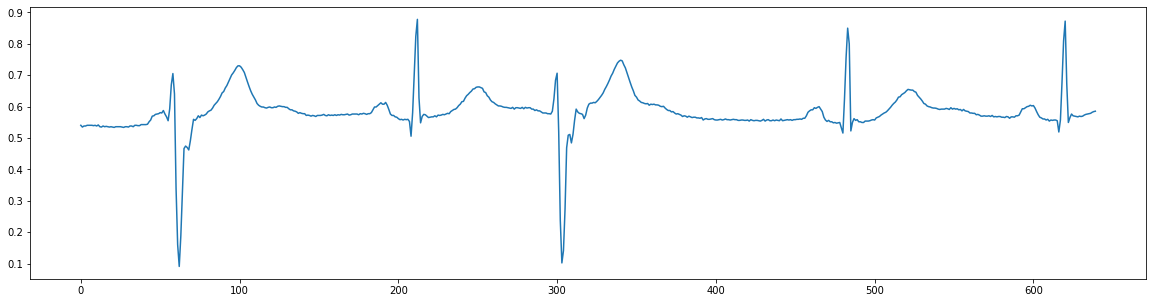

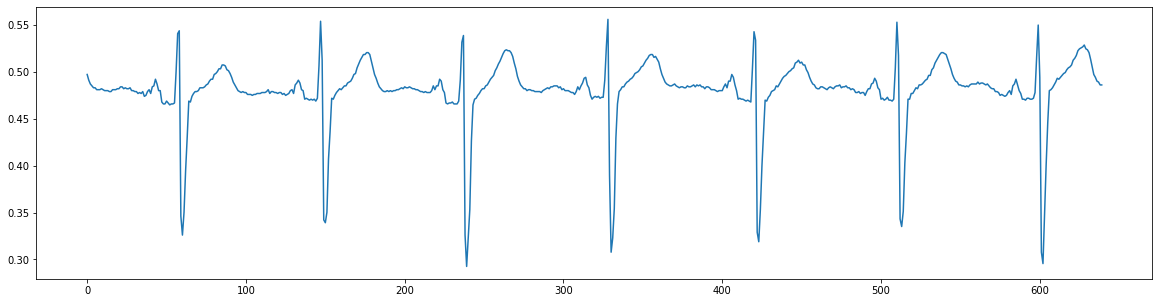

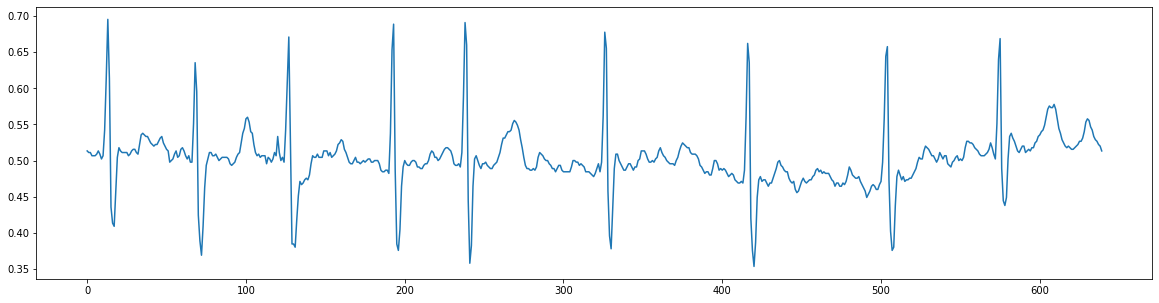

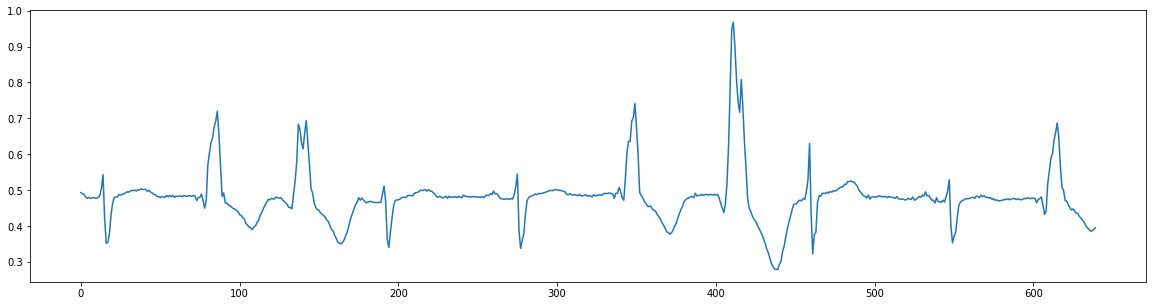

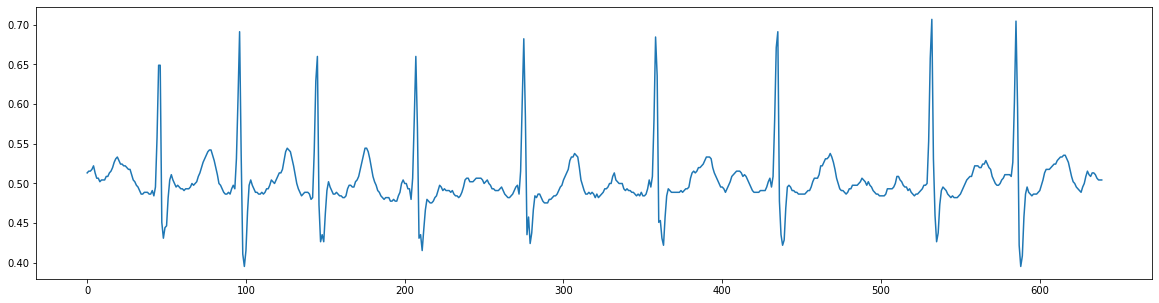

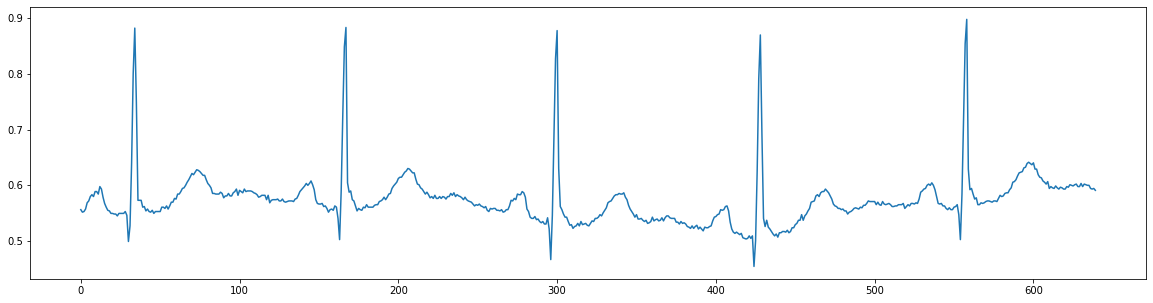

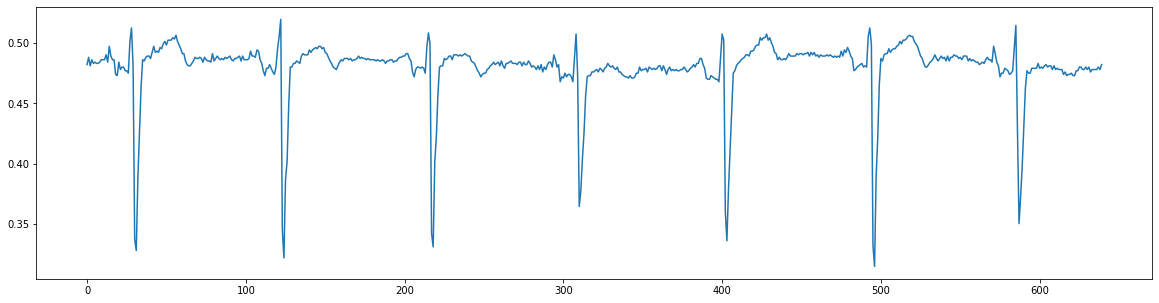

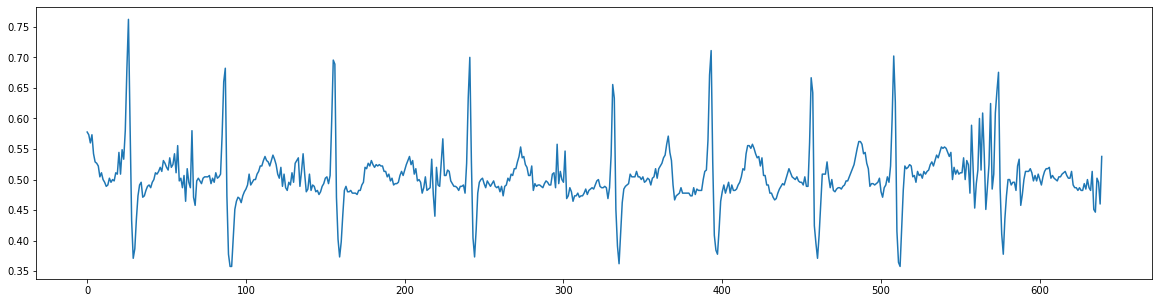

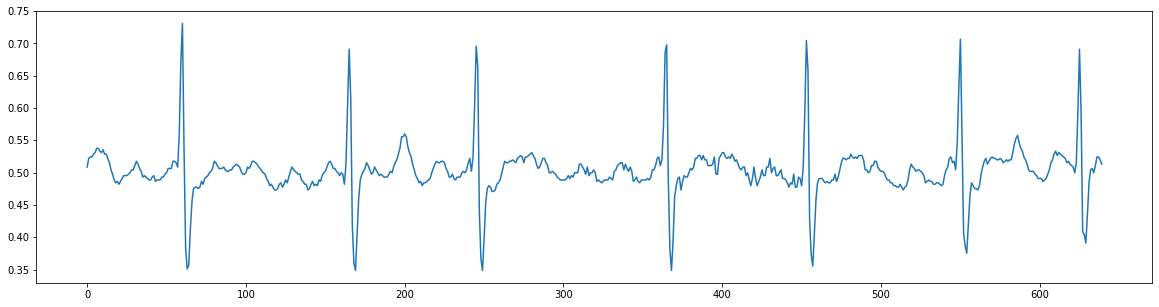

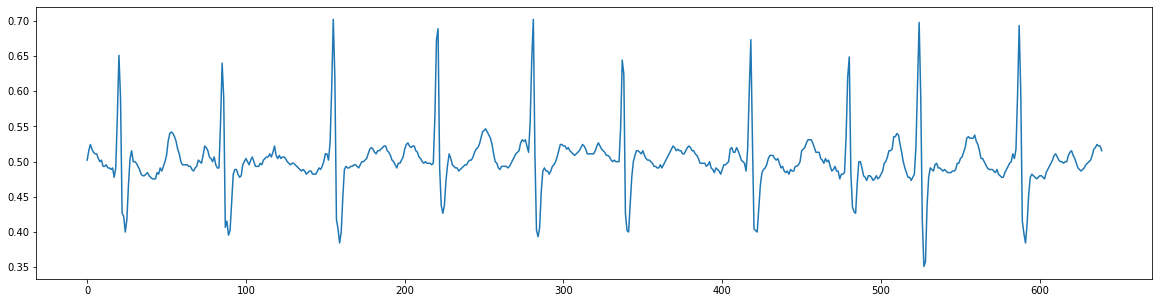

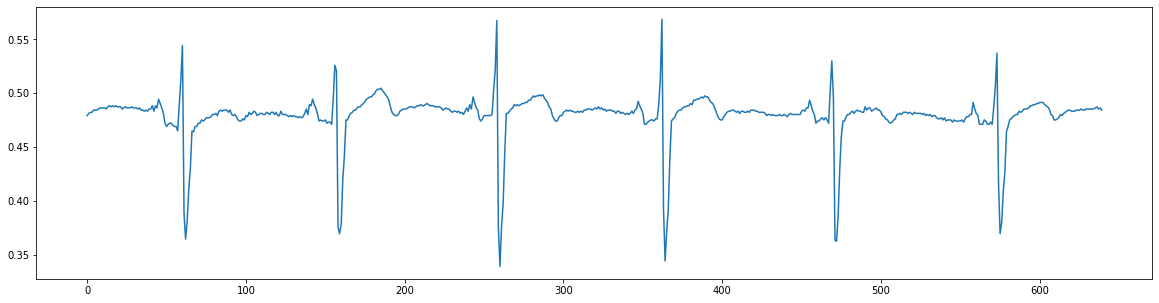

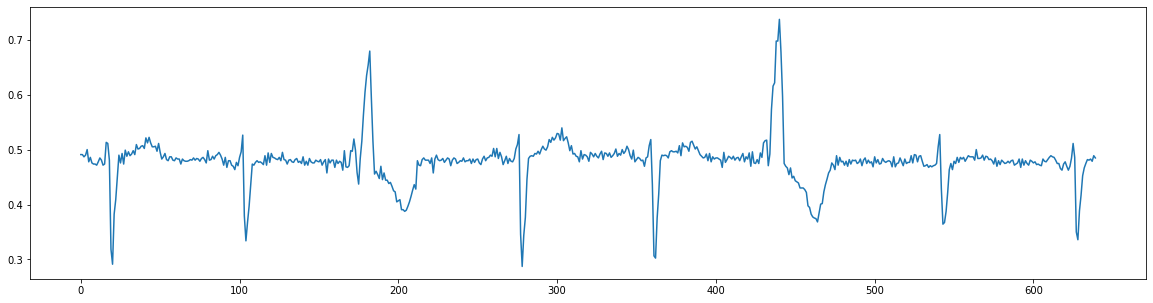

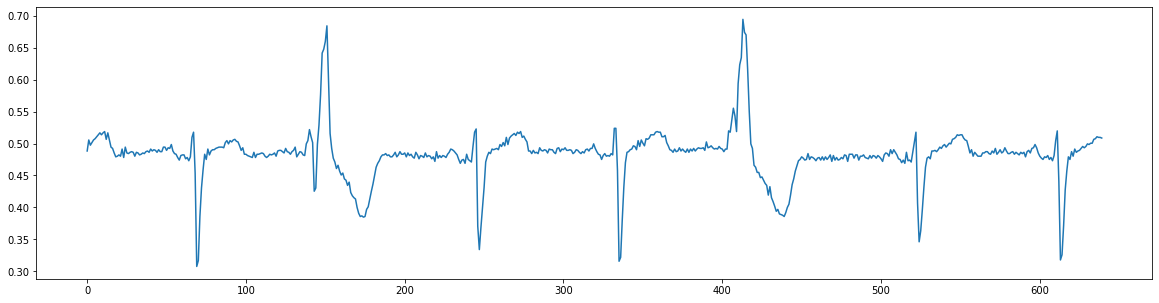

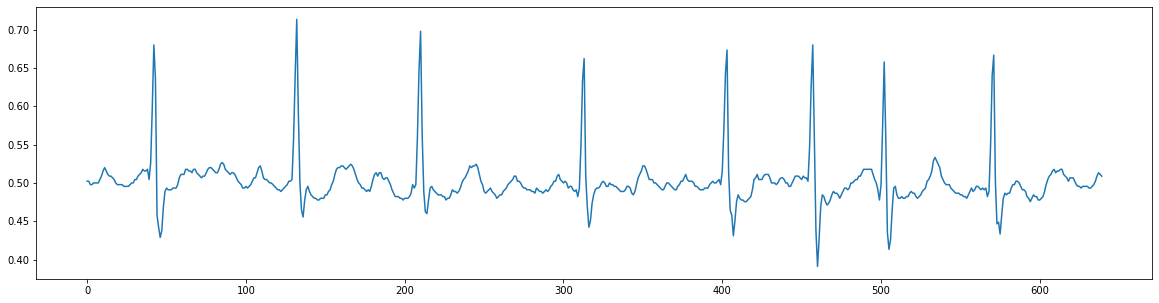

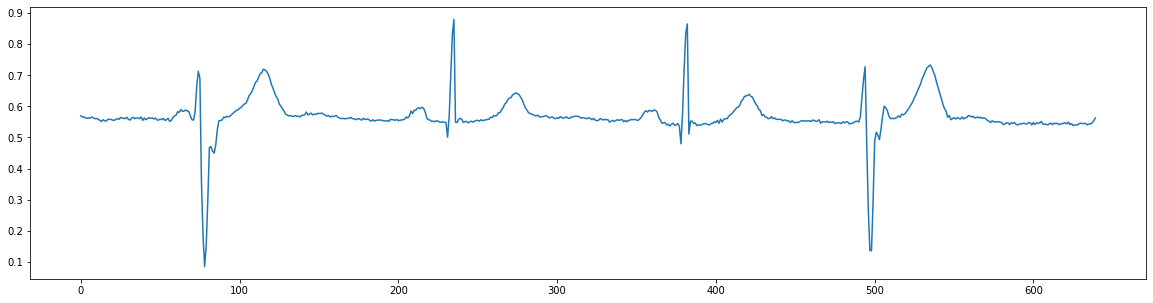

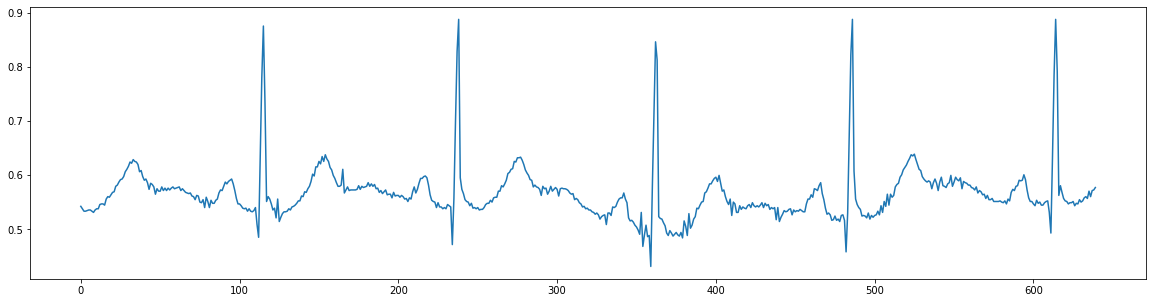

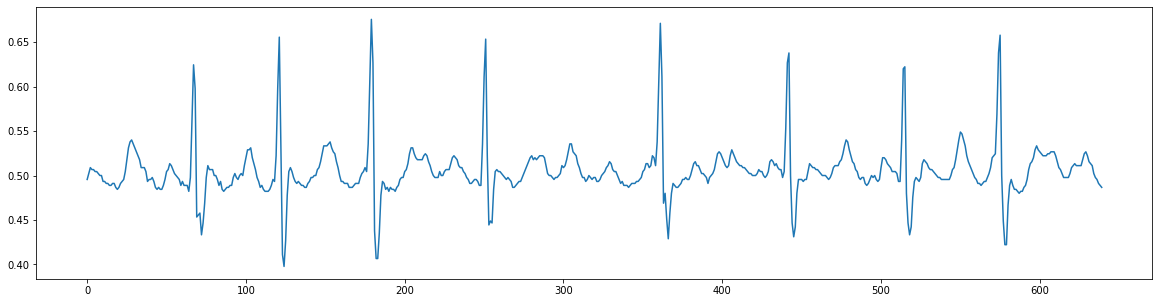

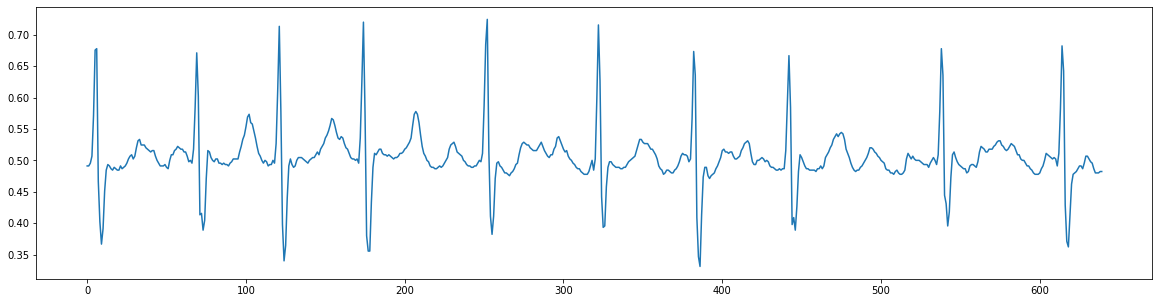

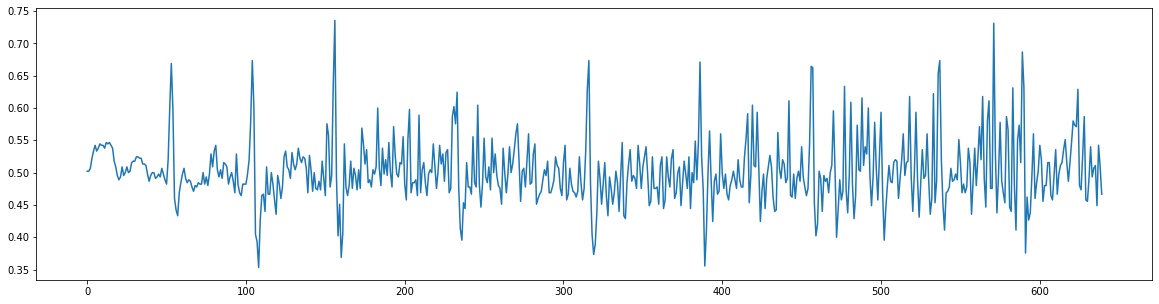

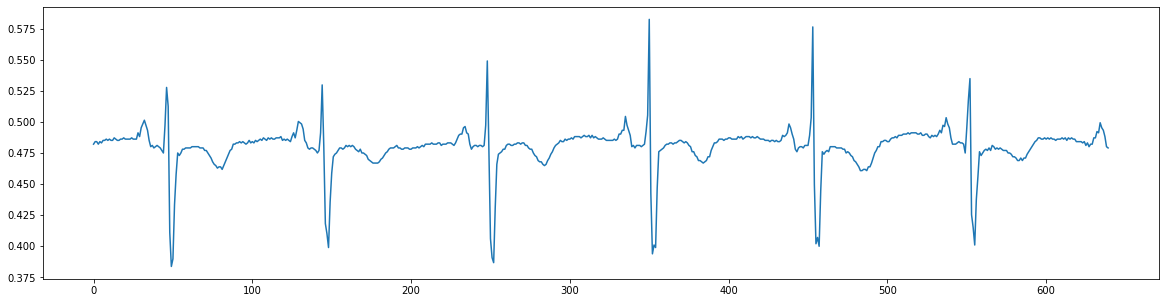

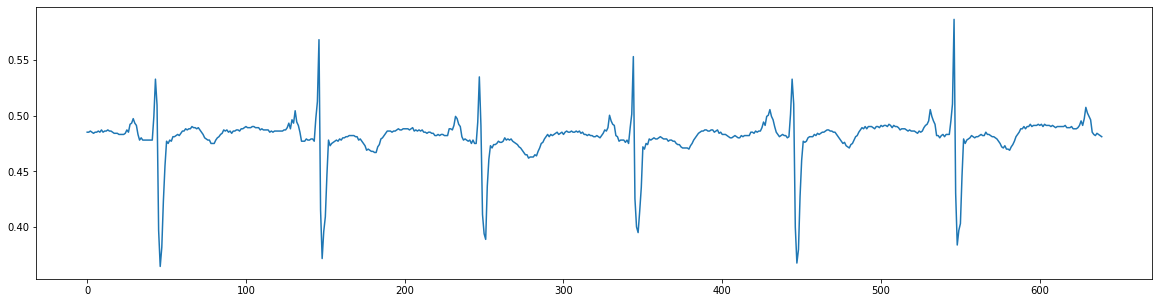

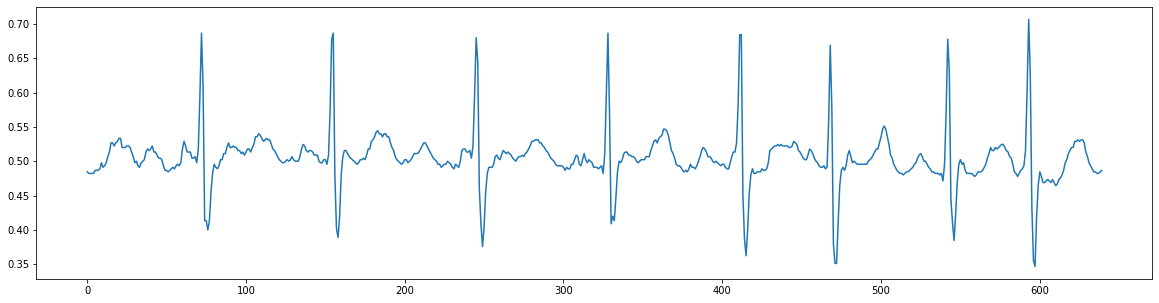

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

show_num = 30
now_num = 0

for data in train_set:
    random_num = np.random.randint(0,50,1)[0]
    if random_num == 3:
        fig = plt.figure(figsize=(20,5))
        ax = fig.add_subplot(111)
        ax.plot(np.arange(len(data)), data.reshape(-1))
        plt.show()
        now_num += 1
    if now_num == show_num:
        break

# Wellysis Data

In [12]:
import os
import numpy as np
import pyedflib

In [13]:
dir_24 = "/works/Data/wellysis/AU/2"
file_list = os.listdir(dir_24)
edf_path_list = []
for fold_name in file_list:
    edf_list = os.listdir(dir_24+"/"+fold_name)
    edf_path_list += [dir_24+"/"+fold_name+"/"+edf for edf in edf_list if edf.endswith(".edf")]
    
print("Total edf file num is : {}".format(len(edf_path_list)))

Total edf file num is : 87


In [14]:
import numpy as np
from scipy.signal import lfilter

def max_normalization(ecg):
    return ecg / max(np.fabs(np.amin(ecg)), np.fabs(np.amax(ecg)))

# =====================================
# == ecg-af-detection-physionet-2017 ==
# =====================================
def low_pass_filtering(ecg):
    # LPF (1-z^-6)^2/(1-z^-1)^2
    b = [1, 0, 0, 0, 0, 0, -2, 0, 0, 0, 0, 0, 1]
    a = [1, -2, 1]

    # transfer function of LPF
    h_LP = lfilter(b, a, np.append([1], np.zeros(12)))

    ecg2 = np.convolve(ecg, h_LP)
    # cancel delay
    ecg2 = np.roll(ecg2, -6)
    return max_normalization(ecg2)


def high_pass_filtering(ecg):
    # HPF = Allpass-(Lowpass) = z^-16-[(1-z^32)/(1-z^-1)]
    b = [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 32, -32, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    a = [1, -1]

    # impulse response iof HPF
    h_HP = lfilter(b, a, np.append([1], np.zeros(32)))
    ecg3 = np.convolve(ecg, h_HP)
    # cancel delay
    ecg3 = np.roll(ecg3, -16)
    return max_normalization(ecg3)


class StandardScaler():
    def __init__(self):
        self.mean = 0
        self.std = 1
        
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)
        
    def transform(self, data):
        return (data - self.mean) / self.std

def make_signal(edf_dir):
    scaler = StandardScaler()
    ECG_MIN = -0.06
    ECG_MAX = 0.12
    with pyedflib.EdfReader(edf_dir) as f:
        ecg = f.readSignal(0)
        ecg = ecg[::2]
        #ecg = low_pass_filtering(ecg)
        #ecg = high_pass_filtering(ecg)
        #ecg[ecg<ECG_MIN] = ECG_MIN
        #ecg[ecg>ECG_MAX] = ECG_MAX
    #scaler.fit(ecg)
    #ecg = scaler.transform(ecg)
    return ecg

def make_datasample(signal, hz, len_sec, over_sec):
    time_len = hz*len_sec
    over_len = hz*over_sec
    # Window
    result = []
    start_idx = hz*60
    while start_idx+time_len <= len(signal)-hz*60:
        sample_data = signal[start_idx:start_idx+time_len]
        start_idx += (time_len-over_len)
        if sample_data.std()>0.001:
            if len(sample_data) == time_len:
                result.append(sample_data)
    result = np.array(result).reshape(-1, time_len, 1)
    return result.astype(np.float32)

def data_preprocessing(path_list, hz, len_sec, over_sec):
    data_col = np.zeros((1,hz*len_sec,1), dtype=np.float32)
    for idx, edf_path in enumerate(path_list):
        signal = make_signal(edf_path)
        preprocessed_signal = make_datasample(signal=signal, hz=hz, len_sec=len_sec, over_sec=over_sec)
        if len(preprocessed_signal)==0:
            continue
        data_col = np.concatenate((data_col, preprocessed_signal), axis=0)
        if idx%100 == 0:
            print("Now Process {:.3f}".format(idx/len(edf_path_list)))

    data_col = data_col[1:]
    return data_col

In [15]:
hz = 128
len_sec = 5
over_sec = 2

In [16]:
data_col1 = data_preprocessing(edf_path_list[:1000], hz=hz, len_sec=len_sec, over_sec=over_sec)

Now Process 0.000


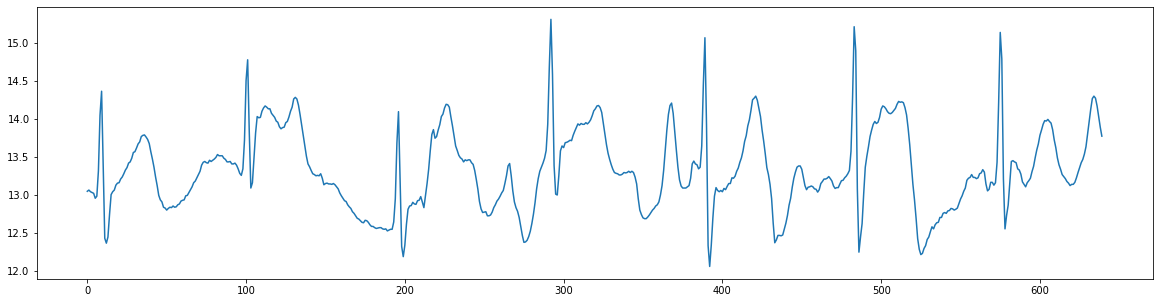

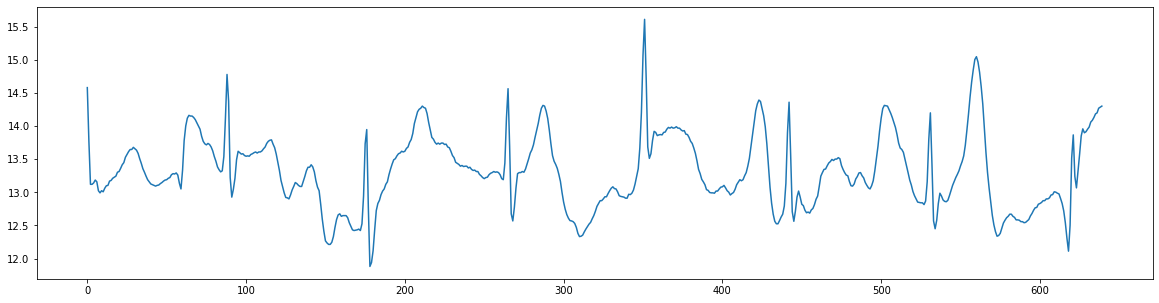

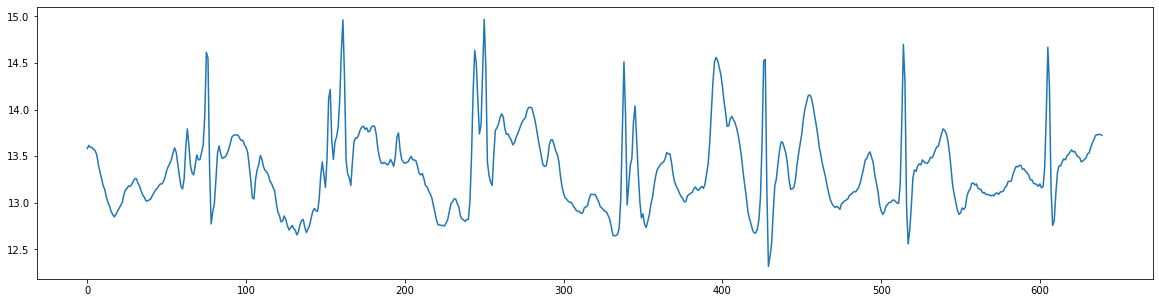

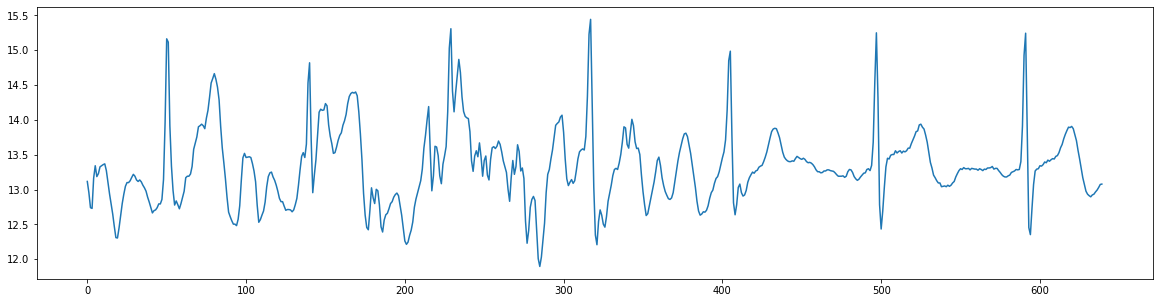

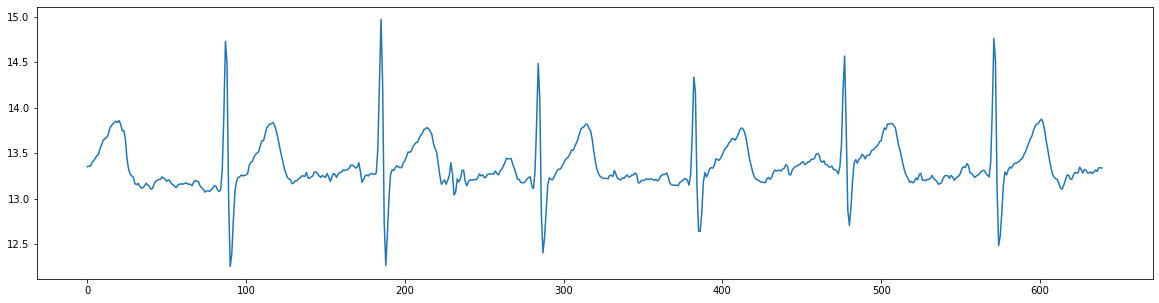

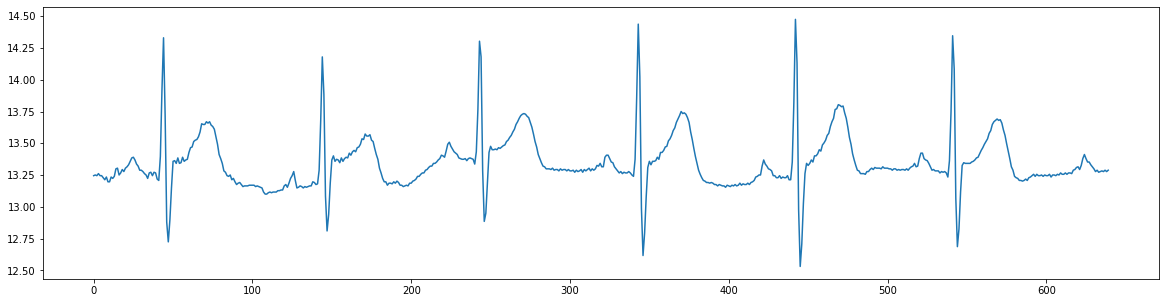

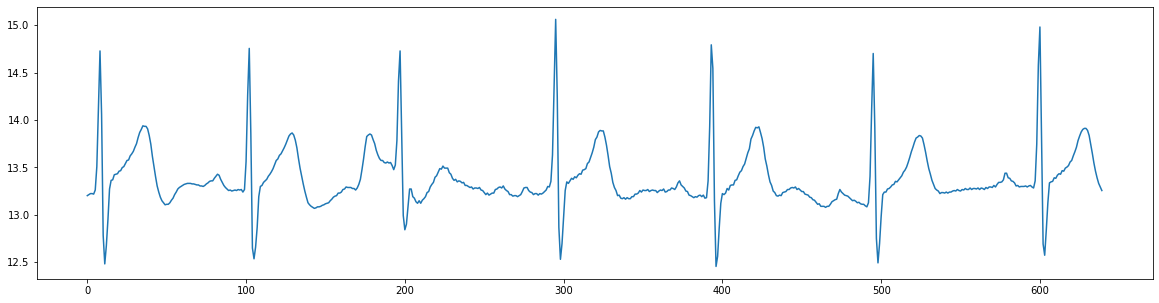

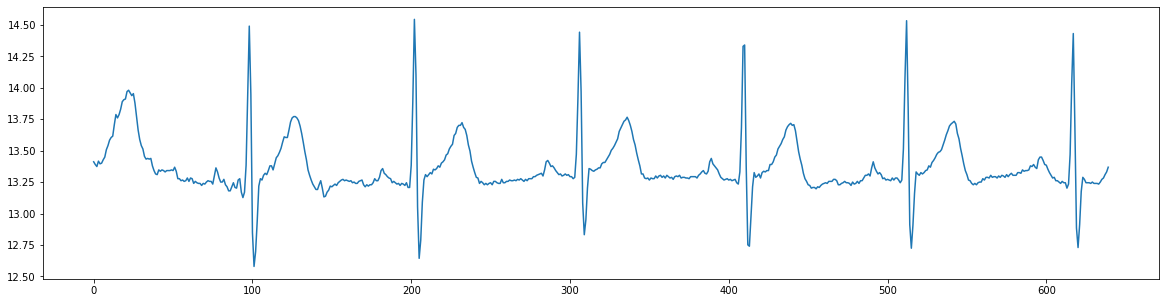

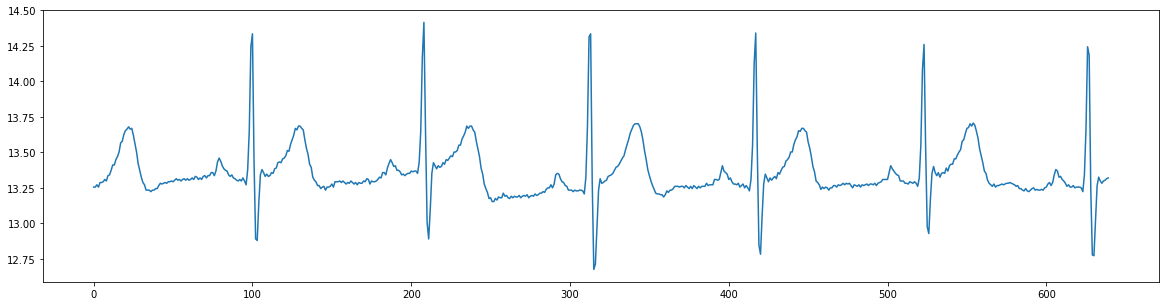

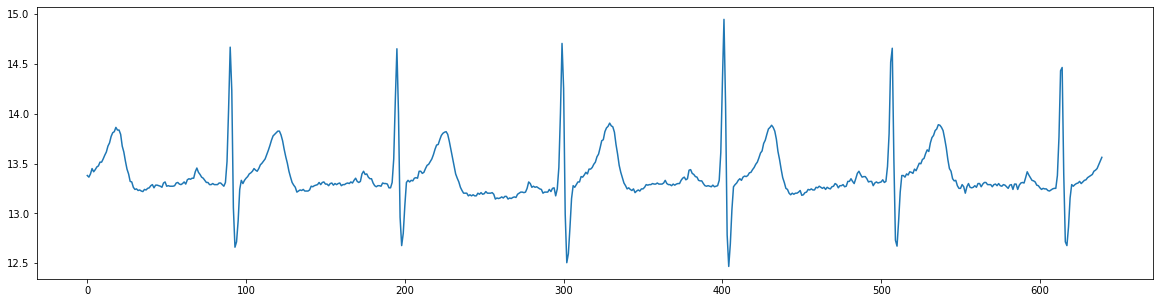

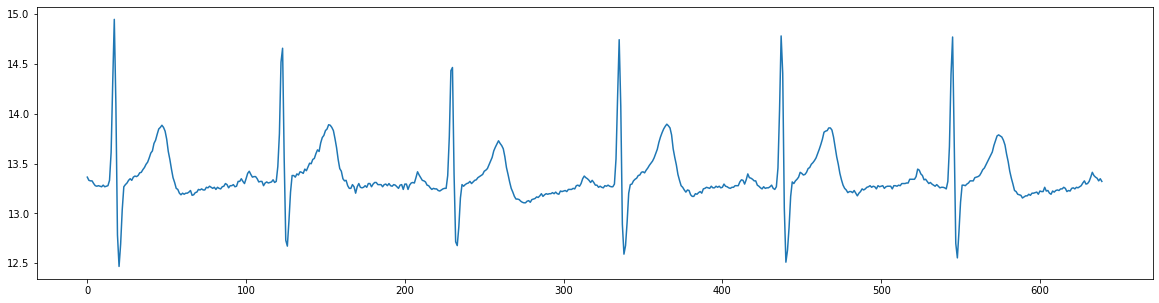

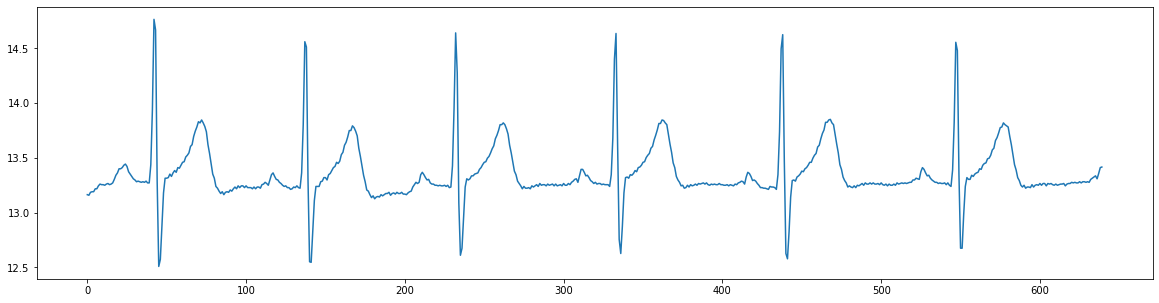

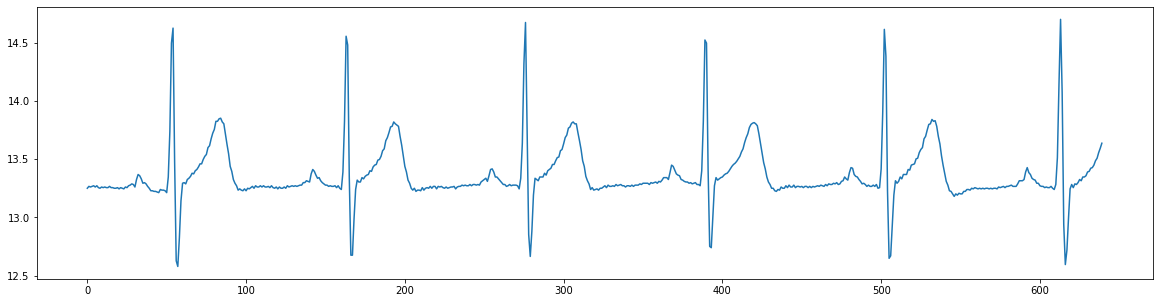

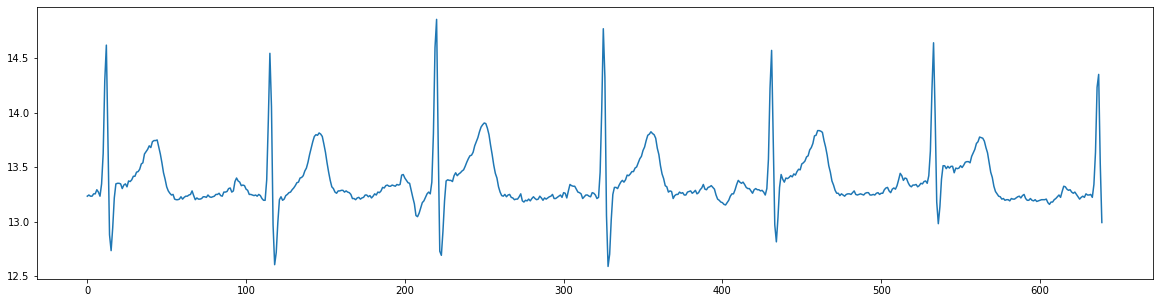

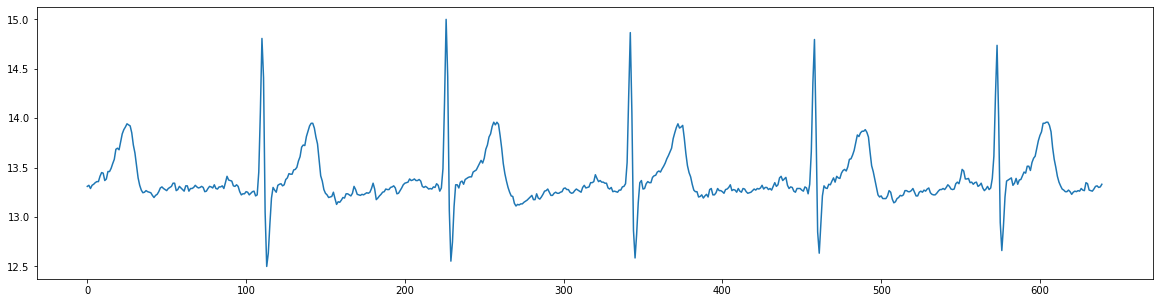

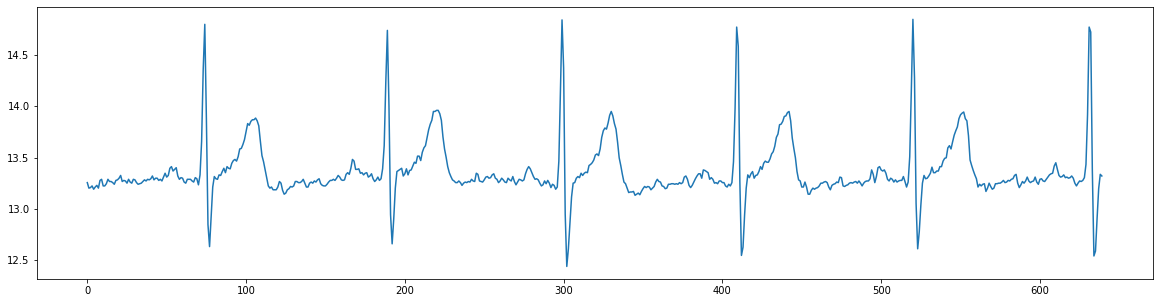

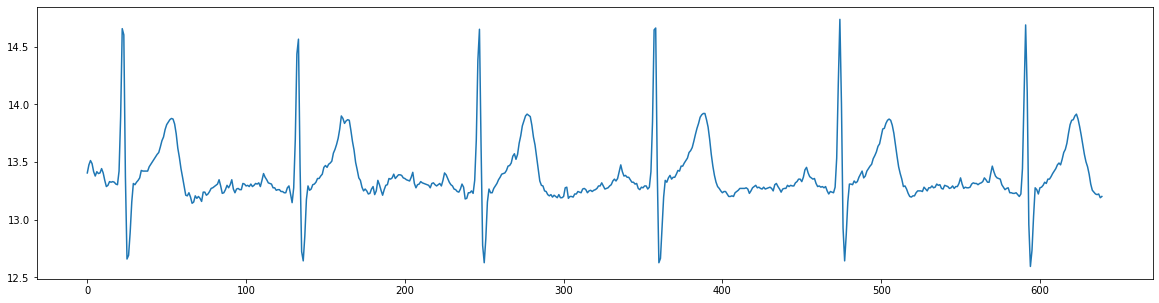

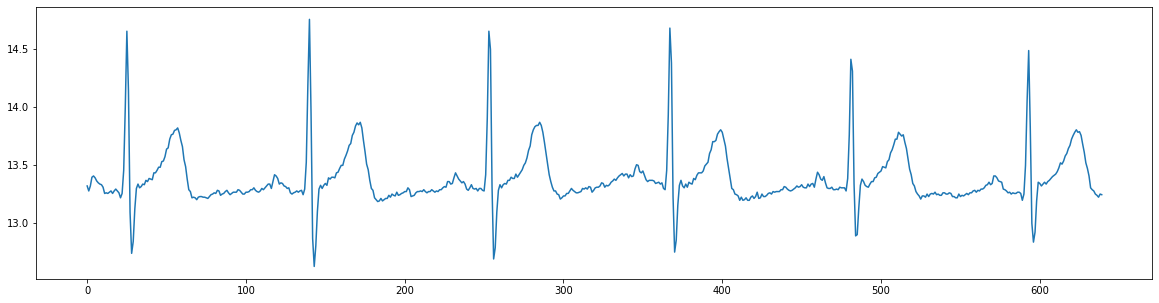

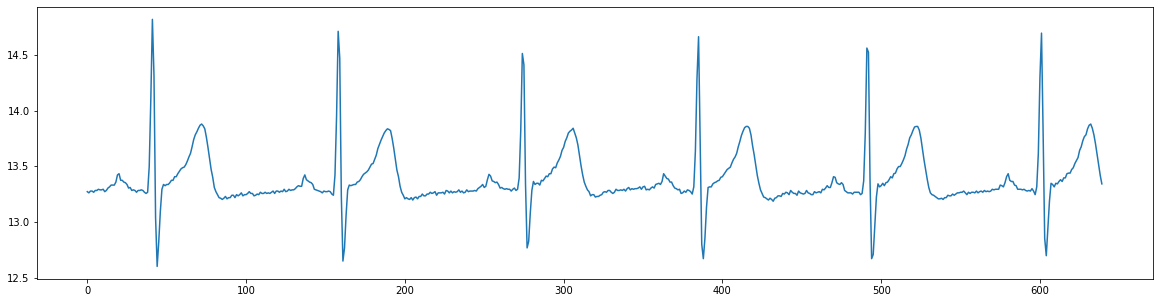

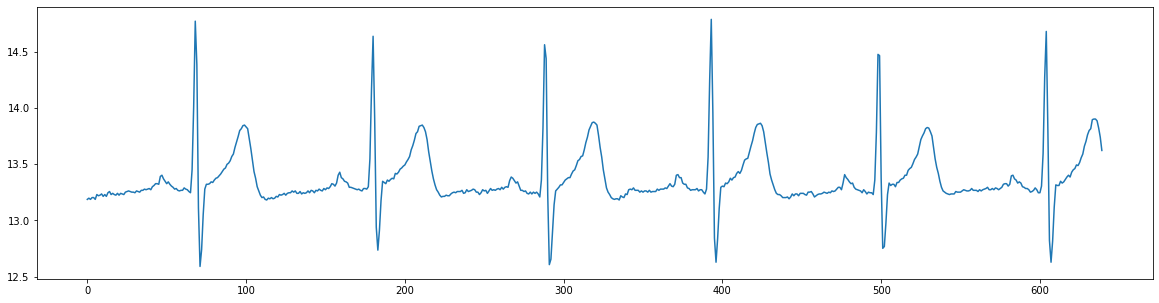

In [19]:
show_num = 20
now_num = 0

for data in data_col1:
    random_num = np.random.randint(0,10,1)[0]
    if random_num == 3:
        fig = plt.figure(figsize=(20,5))
        ax = fig.add_subplot(111)
        ax.plot(np.arange(len(data)), data.reshape(-1))
        plt.show()
        now_num += 1
    if now_num == show_num:
        break

In [325]:
ecg_signal = make_signal(edf_path_list[16])

In [326]:
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5*fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [327]:
filter_signal = butter_bandpass_filter(ecg_signal, 32, 512, 1280)

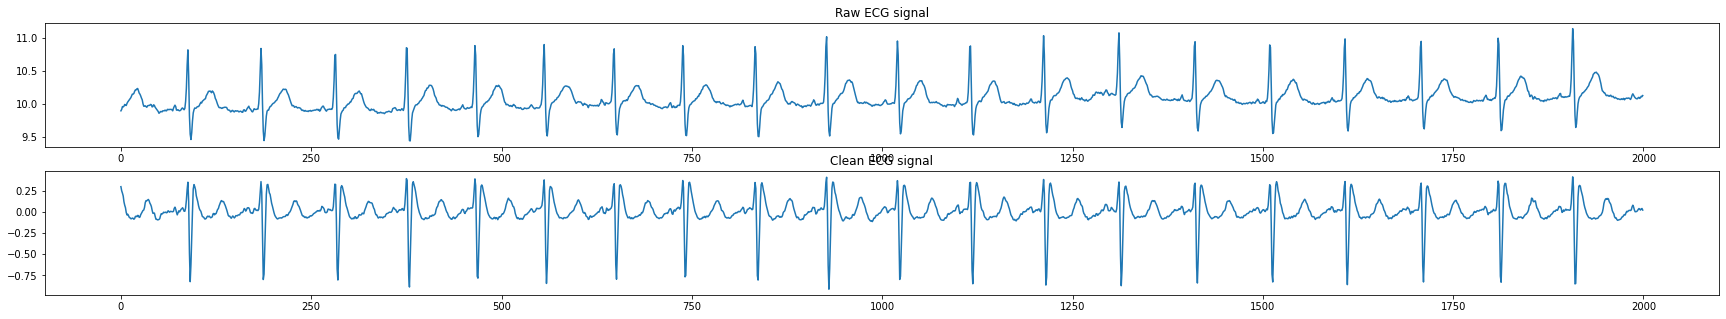

In [328]:
cut_off_start = 6000
see_len = 2000

plt.figure(figsize=(30,5))
ax1 = plt.subplot(211)
plt.plot(ecg_signal[cut_off_start:cut_off_start+see_len])
ax1.set_title("Raw ECG signal")


ax2 = plt.subplot(212)
plt.plot(filter_signal[cut_off_start:cut_off_start+see_len])
ax2.set_title("Clean ECG signal")
plt.show()

In [214]:

## A high pass filter allows frequencies higher than a cut-off value
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False, output='ba')
    return b, a
## A low pass filter allows frequencies lower than a cut-off value
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False, output='ba')
    return b, a
def notch_filter(cutoff, q):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a

def highpass(data, fs, order=5):
    b,a = butter_highpass(cutoff_high, fs, order=order)
    x = lfilter(b,a,data)
    return x

def lowpass(data, fs, order =5):
    b,a = butter_lowpass(cutoff_low, fs, order=order)
    y = lfilter(b,a,data)
    return y

def notch(data, powerline, q):
    b,a = notch_filter(powerline,q)
    z = lfilter(b,a,data)
    return z

def final_filter(data, fs, order=5):
    b, a = butter_highpass(cutoff_high, fs, order=order)
    x = lfilter(b, a, data)
    d, c = butter_lowpass(cutoff_low, fs, order = order)
    y = lfilter(d, c, x)
    #f, e = notch_filter(powerline, 30)
    #z = lfilter(f, e, y)     
    #return z
    return y

In [215]:
ecg_signal = make_signal(edf_path_list[0])

In [268]:
fs = 1280
## Order of five works well with ECG signals
cutoff_high = 32
cutoff_low = 512
powerline = 60
order = 5

filter_signal = final_filter(ecg_signal, fs, order)

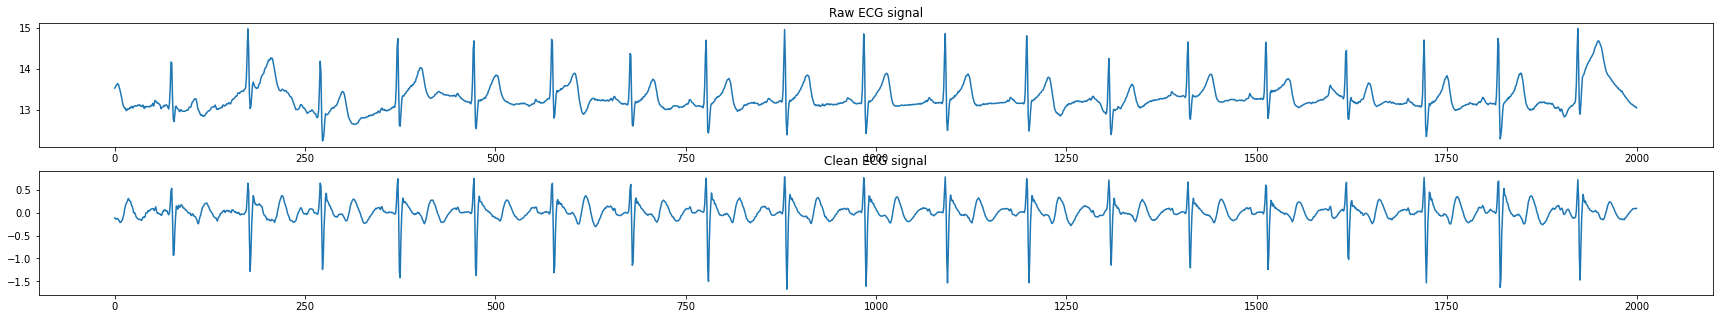

In [269]:
cut_off_start = 1000
see_len = 2000

plt.figure(figsize=(30,5))
ax1 = plt.subplot(211)
plt.plot(ecg_signal[cut_off_start:cut_off_start+see_len])
ax1.set_title("Raw ECG signal")


ax2 = plt.subplot(212)
plt.plot(filter_signal[cut_off_start:cut_off_start+see_len])
ax2.set_title("Clean ECG signal")
plt.show()

In [270]:
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5*fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [279]:
filter_signal = butter_bandpass_filter(ecg_signal, 32, 512, 1280)

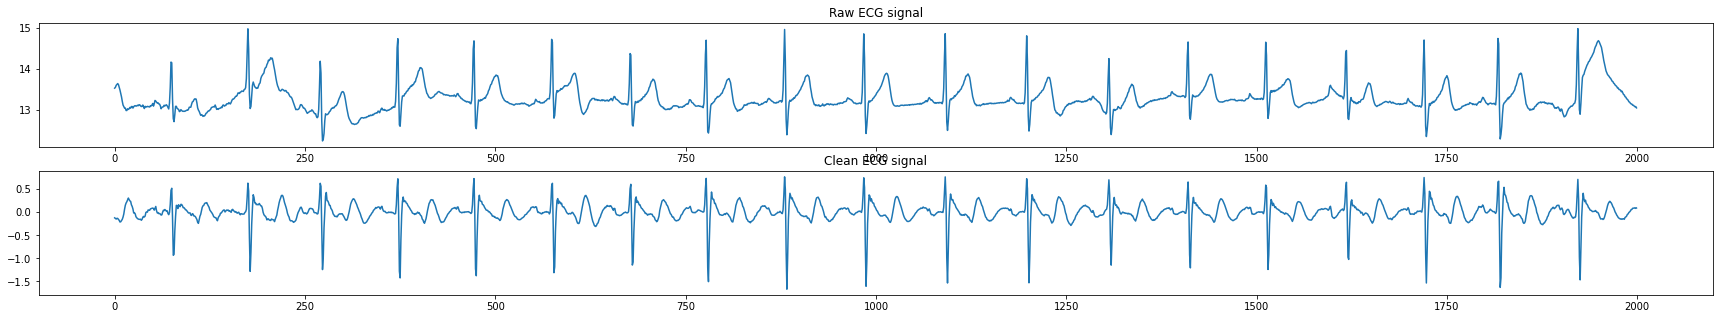

In [280]:
cut_off_start = 1000
see_len = 2000

plt.figure(figsize=(30,5))
ax1 = plt.subplot(211)
plt.plot(ecg_signal[cut_off_start:cut_off_start+see_len])
ax1.set_title("Raw ECG signal")


ax2 = plt.subplot(212)
plt.plot(filter_signal[cut_off_start:cut_off_start+see_len])
ax2.set_title("Clean ECG signal")
plt.show()